In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch import optim, nn
import torchvision 
import time
torch.set_printoptions(precision=10)
torch.set_default_dtype(torch.float64)

/home/edward/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/edward/anaconda3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [3]:
train_labels = train_data.targets
train_images = train_data.data/255 * 2 - 1

In [4]:
createIX = locals()
for ix in range(10):
    createIX['inx_' + str(ix)] = [i for i, x in enumerate(train_labels) if x==ix]
    createIX['pattern_a_' + str(ix)] = []


num = 1
patterns = []

for ix in range(num):
    pattern_a = []

    for iy in range(10):
        tmp_a = createIX['inx_' + str(iy)]

        pattern_a.append(train_images[tmp_a[ix]].reshape(784).detach().numpy())
        
    patterns.append(pattern_a)

In [5]:
patterns = torch.tensor(patterns).reshape(10, 784)

/tmp/ipykernel_3639927/1153506009.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  patterns = torch.tensor(patterns).reshape(10, 784)


In [6]:
patterns[patterns < 0] = -1
patterns[patterns > 0] = 1

In [7]:
class EarlyStopper():
    def __init__(self, patience=5, min_delta=0, filename='optimal_weight.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_val_loss = np.inf
        self.filename = filename

    def early_stop(self, model, val_loss):
            
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            torch.save(model.w_xh, self.filename)
            self.counter = 0
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                model.w_xh = torch.load(self.filename)
                return True
        return False

In [8]:
# RHN class definition
class RHN(nn.Module):
# initialise MRHN

    def __init__(self, inputnodes=1, hiddennodes=1):
        super(RHN, self).__init__()
        # set number of nodes in each input, hidden, output layer
        self.xnodes = inputnodes
        self.hnodes = hiddennodes
        
        #self.w_xh = Variable(torch.tensor((np.random.normal(0, 0.1, (self.xnodes, self.hnodes)))), requires_grad=True)
        self.w_xh = np.random.normal(0, 0.1, (self.xnodes, self.hnodes))
        self.w_xh = torch.tensor(scipy.linalg.orth(self.w_xh), dtype=torch.float64)
    
        self.loss_lst = []

    def forward(self, x):
        return torch.tanh(x @ self.w_xh) @ self.w_xh.T

    def loss(self, y, y_pred):
        return torch.nn.functional.mse_loss(y, y_pred)


    def energy(self, x):
        h_output = x @ self.w_xh
        energy = -torch.linalg.norm(h_output @ h_output.T)
        return energy

    # this is the algorithm  in the paper
    def subspace_train(self, inputs, early_stopper, epochs=100):
        
        inputs = torch.tensor(inputs, dtype=torch.float64)
        
        for ix in range(epochs):
            final_y =  self.forward(inputs)
            loss = self.loss(inputs, final_y)
            print("Epochs : ", ix, "Loss : ", loss.item())
            trans_mat = inputs.T @ final_y
            u, d, v = torch.linalg.svd(trans_mat)
                
            if early_stopper.early_stop(self, loss):
                print("Early stopping condition is satisfied!")
                return self.w_xh
            
            self.w_xh = u @ v @ self.w_xh

        return self.w_xh

    # query the neural network forward
    def query(self, x) :
        stable = False
        inputs = x
        counter = 0
        while(stable == False):
            final_y = torch.sign(self.forward(inputs))

            err = torch.linalg.norm(inputs - final_y)
            #print(err)
            if err < 1e-2 or counter==500:
                stable = True
                #print(counter)
            else:
                inputs = final_y
                counter += 1

        return final_y

In [21]:
class DAM(nn.Module):

    def __init__(self, n_power=20, m_power=30, k_memories = 100, learningrate=1e-2, damp_f=0.998):
        super(DAM, self).__init__()
        # set the parameters for the whole dense associate memory
        self.n_power = n_power
        self.m_power = m_power
        # learning rate
        self.lr = learningrate
        self.beta = 1.0
        self.damp_f = damp_f
        #self.momentum = momentum        
        # lambda x: scipy.special.expit(x)
        self.mu= -0.1          # Weights initialization mean
        self.sigma= 0.1        # Weights initialization std
        self.v_node = 784       # visible node of the neural network
        self.k_memories = k_memories # this is the number of hidden nodes, also is the stored memory
        # initilize the weight
        self.weight_memory = torch.normal(self.mu, self.sigma, (self.k_memories, self.v_node + self.v_node))

        # the updated weight is the same size of the weight memory
        self.updated_weight = torch.zeros((self.k_memories, self.v_node + self.v_node))

        self.thresh_pret = 200    # Length of the temperature ramp
        self.Temp_in=540.       # Initial temperature
        self.Temp_f=540.        # Final temperature
        self.prec=1.0e-30       # Precision of weight update

    # self adaptive learning rate
    def learning_rate(self, num_epochs):
        return self.lr*(self.damp_f**num_epochs)

    
    def helper_matrix(self, v_node, batch):
        aux=-torch.ones((v_node,batch*v_node))

        for digit in range(v_node):
            print("Help Matrix Inside : ", aux[digit, digit*batch:(digit+1)*batch].shape)
            aux[digit,digit*batch:(digit+1)*batch]=1.

        return aux

    # training the neural network
    # since the weight is actually the patterns, thus it is different from the normal backpropogation method
    def train(self, patterns, epochs=10, momentum=0.6):
        
        criterion = torch.nn.MSELoss()

        for epoch in range(epochs):

            #this is a self-adaptive learning rate
            # at the beginning, we have to prepare the parameters needed for training
            act_lr=self.learning_rate(epoch)

            # Temperature ramp
            if epoch<=self.thresh_pret:
                Temp=self.Temp_in+(self.Temp_f-self.Temp_in)*epoch/self.thresh_pret
            else:
                Temp=self.Temp_f

            # calculating the beta
            self.beta=1./Temp**self.n_power
                
            batch = len(patterns)
            target_output = torch.reshape(patterns.T, (-1,))

            # construct the batch input, with 784 image nodes and 784 associative nodes
            extend_img = torch.concatenate((patterns.T, -torch.ones((self.v_node, batch))), axis=0)
            print("Extend Img : ", extend_img.shape)
            # just Uj^alpha and Vj^alpha
            target_u = torch.tile(extend_img, (1, self.v_node))
            print("Target U : ", target_u.shape)
            
            #helper_mat = self.helper_matrix(self.v_node, batch)
            helper_mat = self.helper_matrix(self.v_node, batch)
            
            print("Help matrix : ", helper_mat.shape)
            print("Help Matrix : ", helper_mat)
            
            target_v = torch.concatenate((target_u[:self.v_node,:], helper_mat), axis=0)
            print("Target V : ", target_v.shape)

            WMvv=torch.maximum(self.weight_memory @ target_v, torch.tensor(0))
            WMuu=torch.maximum(self.weight_memory @ target_u, torch.tensor(0))

            # forward path Eq 9
            actual_output = torch.tanh(self.beta*torch.sum(WMvv**self.n_power-WMuu**self.n_power, axis=0))
            reshape_actual_output = torch.reshape(actual_output, (self.v_node, batch))

            Y = actual_output
            t = target_output
            print("Epoch : ", epoch, "Mean Square Error : ", criterion(Y, t).item())


            diff_U = torch.tile((t-Y)**(2*self.m_power-1)*(1-Y**2), (self.k_memories,1))*WMvv**(self.n_power-1)
            diff_V = torch.tile((t-Y)**(2*self.m_power-1)*(1-Y**2), (self.k_memories,1))*WMuu**(self.n_power-1)

            diff_WM = (torch.tile((t-Y)**(2*self.m_power-1)*(1-Y**2), (self.k_memories,1))*WMvv**(self.n_power-1) @ target_v.T) \
                 - (torch.tile((t-Y)**(2*self.m_power-1)*(1-Y**2), (self.k_memories,1))*WMuu**(self.n_power-1) @ target_u.T)

            # this is the momentum
            self.updated_weight = momentum*self.updated_weight + diff_WM
            nc=torch.amax(torch.absolute(self.updated_weight),axis=1).reshape(self.k_memories,1)

            # nc could not be zero, otherwise it will lead to exception
            nc[nc<self.prec]=self.prec
            ncc=torch.tile(nc,(1,self.v_node+self.v_node))
            
            self.weight_memory += act_lr*self.updated_weight/ncc
            self.weight_memory = torch.clip(self.weight_memory, -1, 1)


        return self.weight_memory

    def query(self, test_patterns):
        
        batch = len(test_patterns)
        target_output = torch.reshape(test_patterns, (-1,))
        extend_img = torch.concatenate((test_patterns.T, -torch.ones((self.v_node, batch))), axis=0)
        
        
        target_u=torch.tile(extend_img,(batch, self.v_node))

        helper_mat = self.helper_matrix(self.v_node, batch)
        target_v= torch.concatenate((target_u[:self.v_node,:],helper_mat),axis=0)

        WMvv=torch.maximum(self.weight_memory @ target_v, torch.tensor(0))
        WMuu=torch.maximum(self.weight_memory @ target_u, torch.tensor(0))

        # Forward path, Eq 9
        actual_output = torch.tanh(self.beta*torch.sum(WMvv**self.n_power-WMuu**self.n_power, axis=0))
        reshape_actual_output = torch.reshape(actual_output, (self.v_node, batch))

        return reshape_actual_output


In [22]:
dam = DAM(n_power=40, m_power=50, k_memories = 15, learningrate=1e-2, damp_f=0.998)

In [23]:
tic = time.perf_counter()
dam.train(patterns, epochs=1)
toc = time.perf_counter()
print(f"Training Time {toc - tic:0.4f} seconds")

Extend Img :  torch.Size([1568, 10])
Target U :  torch.Size([1568, 7840])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.Size([10])
Help Matrix Inside :  torch.S

In [12]:
rhn = RHN(784, 15)
early_stopper = EarlyStopper(10, 0, filename='rhn_optimal_weight.pth')

In [13]:
tic = time.perf_counter()
weight_memory = rhn.subspace_train(patterns, early_stopper, epochs=3000)
toc = time.perf_counter()
print(f"Training Time {toc - tic:0.4f} seconds")

Epochs :  0 Loss :  0.9857219762400791
Epochs :  1 Loss :  0.7855242841505273


/tmp/ipykernel_956824/4223279585.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float64)


Epochs :  2 Loss :  0.7610367770094023
Epochs :  3 Loss :  0.7583821417434102
Epochs :  4 Loss :  0.7577170919855565
Epochs :  5 Loss :  0.7565762559432362
Epochs :  6 Loss :  0.7564921560879352
Epochs :  7 Loss :  0.7556243786965371
Epochs :  8 Loss :  0.7550494671287041
Epochs :  9 Loss :  0.7550495667796764
Epochs :  10 Loss :  0.7550500005915338
Epochs :  11 Loss :  0.7550501971821653
Epochs :  12 Loss :  0.7550502757304111
Epochs :  13 Loss :  0.7550503061830524
Epochs :  14 Loss :  0.7550503178769359
Epochs :  15 Loss :  0.7550503223517283
Epochs :  16 Loss :  0.7550503240617062
Epochs :  17 Loss :  0.7550503247147858
Epochs :  18 Loss :  0.7550503249641548
Early stopping condition is satisfied!
Training Time 1.3472 seconds


In [14]:
def cover(patterns, pixels):
    cov_pat = []
    for ix in range(len(patterns)):
        pat = patterns[ix].clone()
        for iy in range(int(pixels)):
            pat[iy] = 0
        cov_pat.append(pat)
    return np.array(cov_pat)

In [15]:
cover_patterns = cover(patterns, 392)

/tmp/ipykernel_956824/2896760023.py:8: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(cov_pat)
/tmp/ipykernel_956824/2896760023.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(cov_pat)


In [32]:
noise_patterns = patterns + torch.normal(0, 2, (10,784))

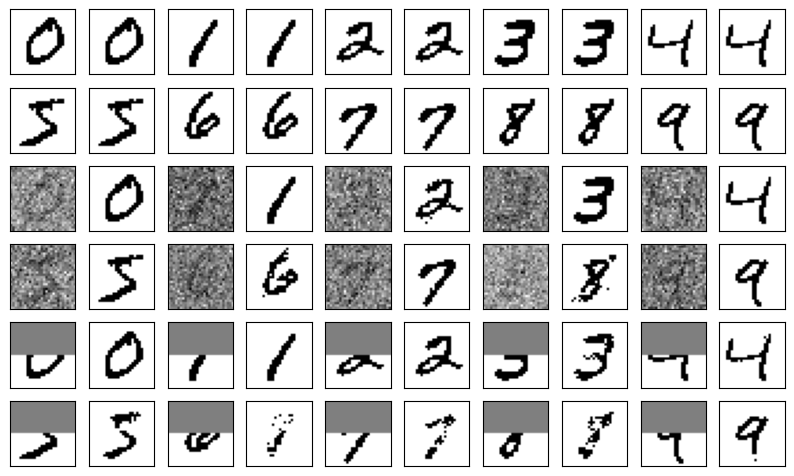

In [33]:
plt.rcParams.update({'font.size': 50})
plt.figure(figsize=(10, 10))
counter = 1

for index in range(10):

    plt.subplot(10, 10, counter)
    input_pattern = patterns[index].reshape(28, 28)
    plt.imshow(input_pattern, cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1

    plt.subplot(10, 10, counter)
    image = dam.query(input_pattern.reshape(1, 784))
    plt.imshow(np.sign(image).reshape(28, 28), cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1
    
for index in range(10):

    plt.subplot(10, 10, counter)
    input_pattern = noise_patterns[index].reshape(28, 28)
    plt.imshow(input_pattern, cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1

    plt.subplot(10, 10, counter)
    image = dam.query(input_pattern.reshape(1, 784))
    plt.imshow(np.sign(image).reshape(28, 28), cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1
    
for index in range(10):

    plt.subplot(10, 10, counter)
    input_pattern = cover_patterns[index].reshape(28, 28)
    plt.imshow(input_pattern, cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1

    plt.subplot(10, 10, counter)
    image = dam.query(input_pattern.reshape(1, 784))
    plt.imshow(np.sign(image).reshape(28, 28), cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1

plt.show()

/tmp/ipykernel_956824/2534150302.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = rhn.query(torch.tensor(input_pattern).reshape(784)).detach().numpy()
/tmp/ipykernel_956824/2534150302.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = rhn.query(torch.tensor(input_pattern).reshape(784)).detach().numpy()
/tmp/ipykernel_956824/2534150302.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = rhn.query(torch.tensor(input_pattern).reshape(784)).detach().numpy()


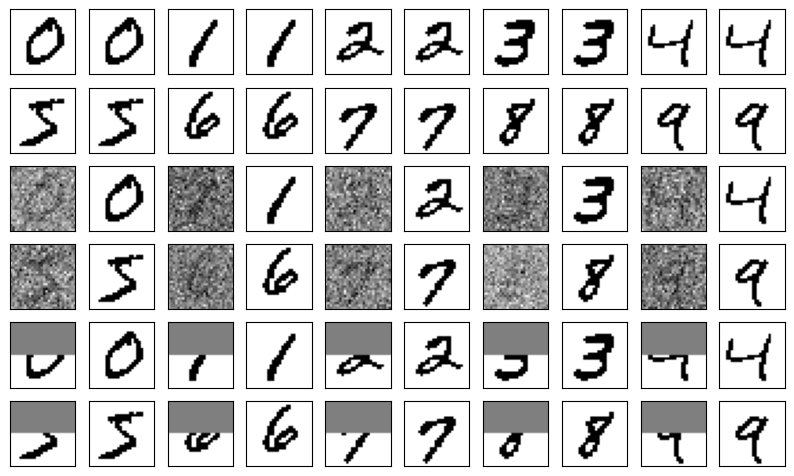

In [34]:
plt.rcParams.update({'font.size': 50})
plt.figure(figsize=(10, 10))
counter = 1

for index in range(10):

    plt.subplot(10, 10, counter)
    input_pattern = patterns[index].reshape(28, 28)
    plt.imshow(input_pattern, cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1

    plt.subplot(10, 10, counter)
    image = rhn.query(torch.tensor(input_pattern).reshape(784)).detach().numpy()
    plt.imshow(np.sign(image).reshape(28, 28), cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1
    
for index in range(10):

    plt.subplot(10, 10, counter)
    input_pattern = noise_patterns[index].reshape(28, 28)
    plt.imshow(input_pattern, cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1

    plt.subplot(10, 10, counter)
    image = rhn.query(torch.tensor(input_pattern).reshape(784)).detach().numpy()
    plt.imshow(np.sign(image).reshape(28, 28), cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1
    
for index in range(10):
    
    plt.subplot(10, 10, counter)
    input_pattern = cover_patterns[index].reshape(28, 28)
    plt.imshow(input_pattern, cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1

    plt.subplot(10, 10, counter)
    image = rhn.query(torch.tensor(input_pattern).reshape(784)).detach().numpy()
    plt.imshow(np.sign(image).reshape(28, 28), cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1

plt.show()

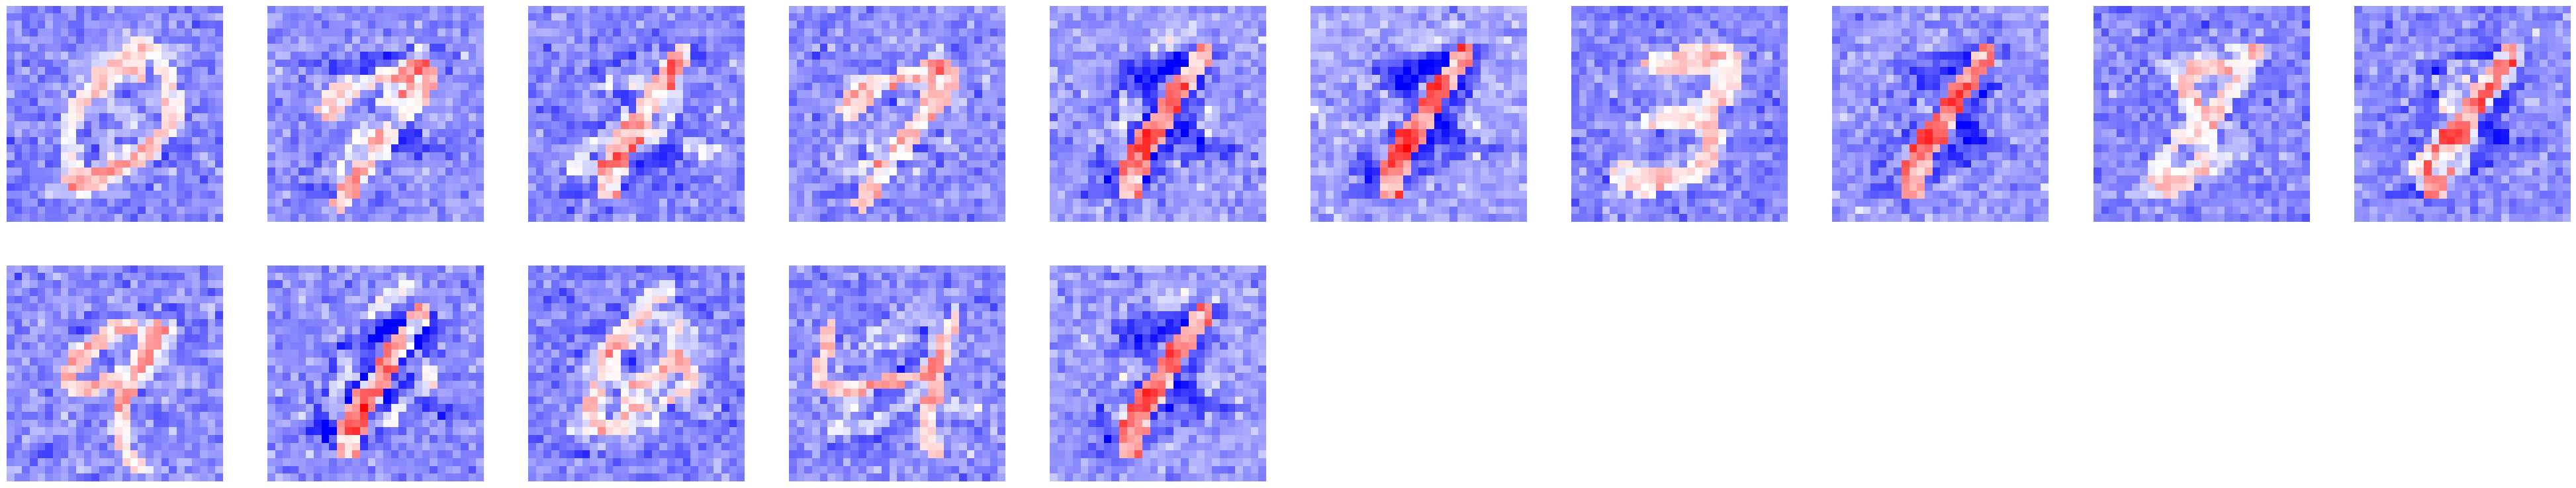

In [30]:
# plot of weight memory
plt.rcParams.update({'font.size': 50})
plt.figure(figsize=(50,50))
counter = 1
weight = dam.weight_memory[:,:784]
nc=torch.amax(torch.absolute(weight))
for ix in range(15):    
    plt.subplot(10, 10, counter)
    #weight = dam.weight_memory[:,:784]
    plt.imshow(weight[ix].reshape(28, 28), cmap='bwr', vmin=-nc, vmax=nc)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.axis('off')
    counter += 1
plt.show()

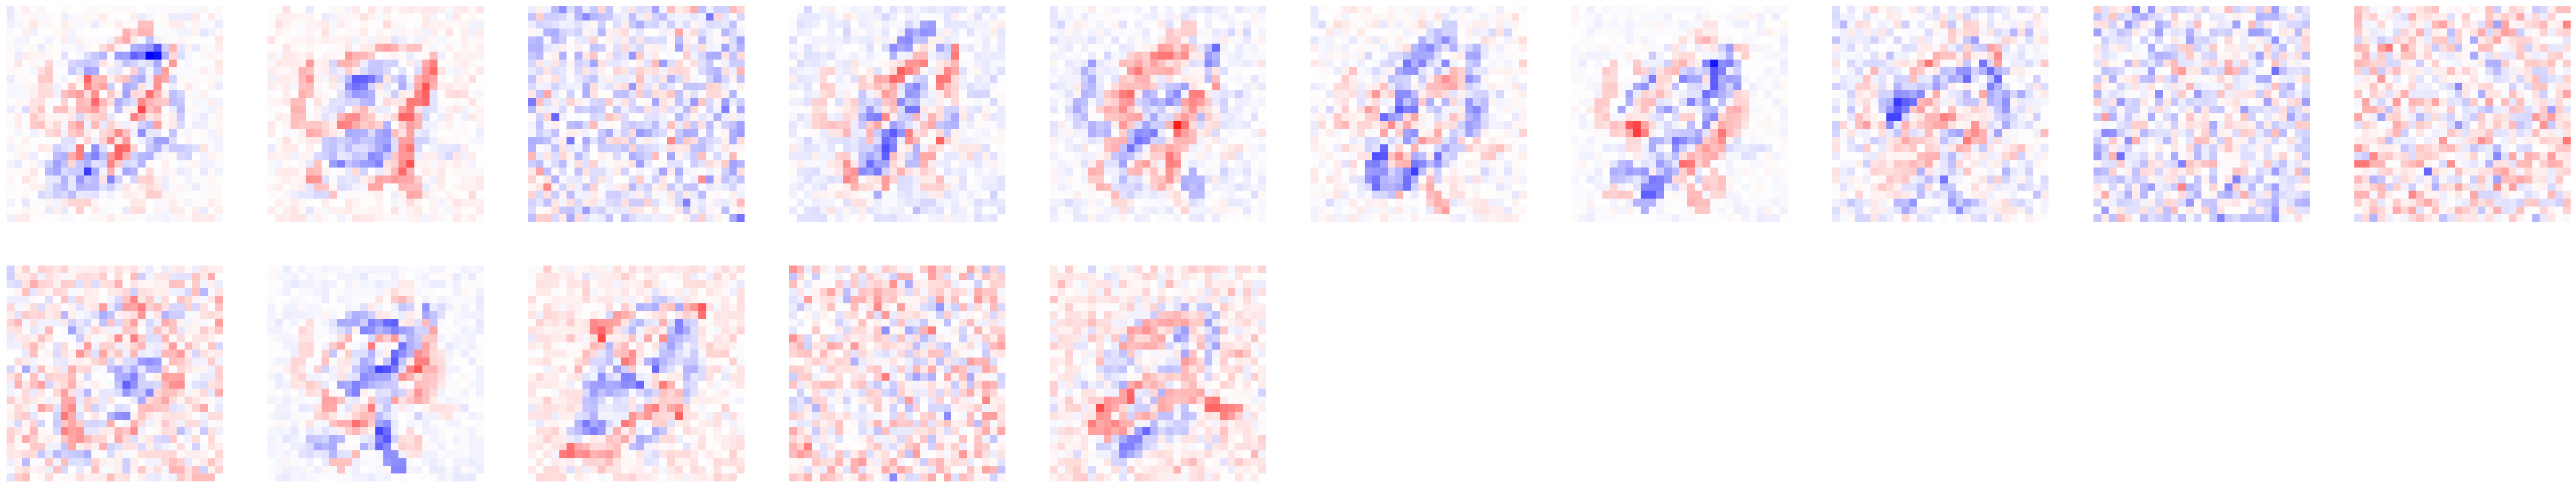

In [31]:
plt.rcParams.update({'font.size': 50})
plt.figure(figsize=(50,50))
weight = rhn.w_xh
nc=np.amax(np.absolute(weight.detach().numpy()))
counter = 1
for ix in range(15):    
    plt.subplot(10, 10, counter)
    plt.imshow(weight[:,ix].reshape(28, 28), cmap='bwr', vmin=-nc, vmax=nc)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.axis('off')
    counter += 1
plt.show()